# The Product Pricer Continued

A model that can estimate how much something costs, from its description.

## Data Curation Part 2

Today we'll extend our dataset to a greater coverage, and craft it into an excellent dataset for training.  
Data curation can seem less exciting than other things we work on, but it's a crucial part of the LLM engineers' responsibility and an important craft to hone, so that you can build your own commercial solutions with high quality datasets.

The dataset is here:  
https://huggingface.co/datasets/McAuley-Lab/Amazon-Reviews-2023

And the folder with all the product datasets is here:  
https://huggingface.co/datasets/McAuley-Lab/Amazon-Reviews-2023/tree/main/raw/meta_categories

## Important Note - read me first please

We are about to craft a massive dataset of 400,000 items covering multiple types of product. In Week 7 we will be using this data to train our own model. It's a pretty big dataset, and depending on the GPU you select, training could take 20+ hours. It will be really good fun, but it could cost a few dollars in compute units.

As an alternative, if you want to keep things quick & low cost, you can work with a smaller dataset focused only on Home Appliances. You'll be able to cover the same learning points; the results will be good -- not quite as good as the full dataset, but still pretty amazing! If you'd prefer to do this, I've set up an alternative jupyter notebook in this folder called `lite.ipynb` that you should use in place of this one.



In [1]:
# imports

import os
import random
from dotenv import load_dotenv
from huggingface_hub import login
from datasets import load_dataset, Dataset, DatasetDict
from loaders import ItemLoader
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
import numpy as np
import pickle

Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [2]:
# environment

load_dotenv(override=True)
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', 'your-key-if-not-using-env')
os.environ['ANTHROPIC_API_KEY'] = os.getenv('ANTHROPIC_API_KEY', 'your-key-if-not-using-env')
os.environ['HF_TOKEN'] = os.getenv('HF_TOKEN', 'your-key-if-not-using-env')

In [3]:
# Log in to HuggingFace

hf_token = os.environ['HF_TOKEN']
login(hf_token, add_to_git_credential=True)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [4]:
# One more import after HF login

from items import Item

In [5]:
%matplotlib inline

## The ItemLoader code

Look in loaders.py - there's some useful code to make life easier for us

In [6]:
# Load in the same dataset as last time

items = ItemLoader("Appliances").load(workers=4)

Loading dataset Appliances


100%|██████████████████████████████████████████████████████████████████████████████████| 95/95 [01:17<00:00,  1.23it/s]

Completed Appliances with 30,016 datapoints in 1.3 mins


In [7]:
# Look for a familiar item..
print(items[1].prompt)

How much does this cost to the nearest dollar?

Door Pivot Block - Compatible Kenmore KitchenAid Maytag Whirlpool Refrigerator - Replaces - Quick DIY Repair Solution
Pivot Block For Vernicle Mullion Strip On Door - A high-quality exact equivalent for part numbers and Compatibility with major brands - Door Guide is compatible with Whirlpool, Amana, Dacor, Gaggenau, Hardwick, Jenn-Air, Kenmore, KitchenAid, and Maytag. Quick DIY repair - Refrigerator Door Guide Pivot Block Replacement will help if your appliance door doesn't open or close. Wear work gloves to protect your hands during the repair process. Attentive support - If you are uncertain about whether the block fits your refrigerator, we will help. We generally put forth a valiant effort to guarantee you are totally

Price is $17.00


## Now to SCALE UP

Let's look at all datasets of all the items that you might find in a large home retail store - electrical, electronic, office and related, but not clothes / beauty / books.

In [17]:
dataset_names = [
    "Automotive",
    "Electronics",
    "Office_Products",
    "Tools_and_Home_Improvement",
    "Cell_Phones_and_Accessories",
    "Toys_and_Games",
    "Appliances",
    "Musical_Instruments",
]

In [20]:
items = []
for dataset_name in dataset_names:
    loader = ItemLoader(dataset_name)
    items.extend(loader.load(workers=8))

# Now, time for a coffee break!!
# By the way, I put the biggest datasets first.. it gets faster.

Loading dataset Automotive


100%|██████████████████████████████████████████████████████████████████████████████| 2004/2004 [38:07<00:00,  1.14s/it]

Completed Automotive with 947,830 datapoints in 40.1 mins


Loading dataset Electronics


100%|██████████████████████████████████████████████████████████████████████████████| 1611/1611 [22:31<00:00,  1.19it/s]

Completed Electronics with 454,613 datapoints in 25.1 mins


Loading dataset Office_Products


100%|████████████████████████████████████████████████████████████████████████████████| 711/711 [10:27<00:00,  1.13it/s]

Completed Office_Products with 246,745 datapoints in 11.2 mins


Loading dataset Tools_and_Home_Improvement


100%|██████████████████████████████████████████████████████████████████████████████| 1474/1474 [23:41<00:00,  1.04it/s]

Completed Tools_and_Home_Improvement with 552,296 datapoints in 25.3 mins


Loading dataset Cell_Phones_and_Accessories


100%|██████████████████████████████████████████████████████████████████████████████| 1289/1289 [12:56<00:00,  1.66it/s]

Completed Cell_Phones_and_Accessories with 240,374 datapoints in 14.2 mins


Loading dataset Toys_and_Games


meta_Toys_and_Games.jsonl:   0%|          | 0.00/2.64G [00:00<?, ?B/s]

Generating full split:   0%|          | 0/890874 [00:00<?, ? examples/s]

100%|████████████████████████████████████████████████████████████████████████████████| 891/891 [13:51<00:00,  1.07it/s]

Completed Toys_and_Games with 348,609 datapoints in 26.3 mins


Loading dataset Appliances


100%|██████████████████████████████████████████████████████████████████████████████████| 95/95 [01:17<00:00,  1.23it/s]

Completed Appliances with 30,016 datapoints in 1.4 mins


Loading dataset Musical_Instruments


meta_Musical_Instruments.jsonl:   0%|          | 0.00/632M [00:00<?, ?B/s]

Generating full split:   0%|          | 0/213593 [00:00<?, ? examples/s]

100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [02:58<00:00,  1.20it/s]

Completed Musical_Instruments with 69,275 datapoints in 5.7 mins


In [21]:
print(f"A grand total of {len(items):,} items")

A grand total of 2,889,758 items


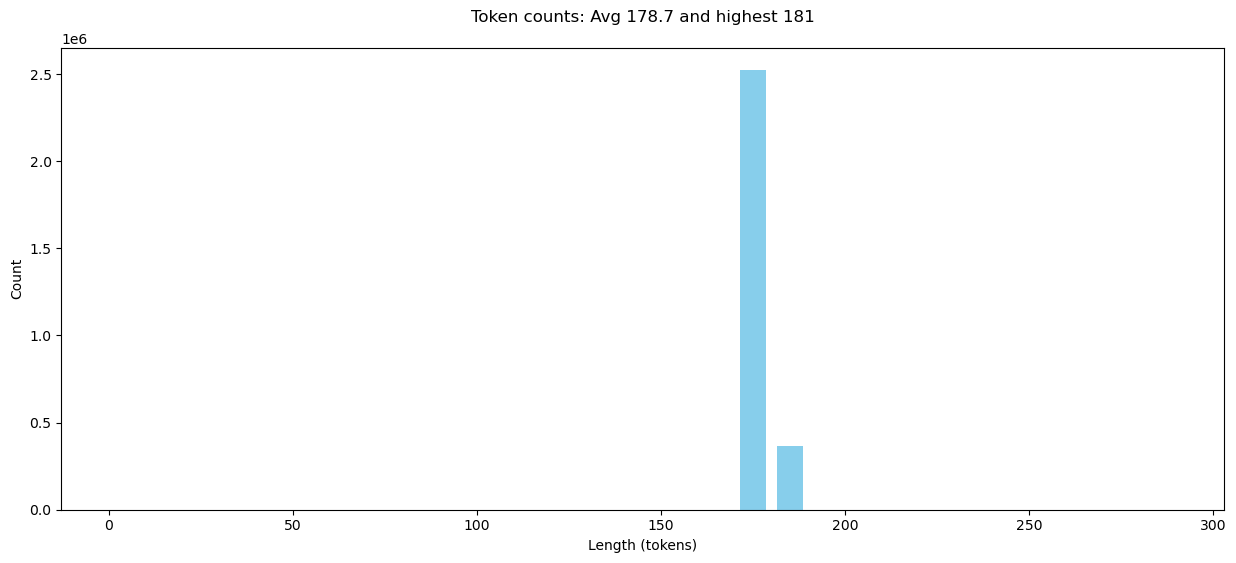

In [22]:
# Plot the distribution of token counts again

tokens = [item.token_count for item in items]
plt.figure(figsize=(15, 6))
plt.title(f"Token counts: Avg {sum(tokens)/len(tokens):,.1f} and highest {max(tokens):,}\n")
plt.xlabel('Length (tokens)')
plt.ylabel('Count')
plt.hist(tokens, rwidth=0.7, color="skyblue", bins=range(0, 300, 10))
plt.show()

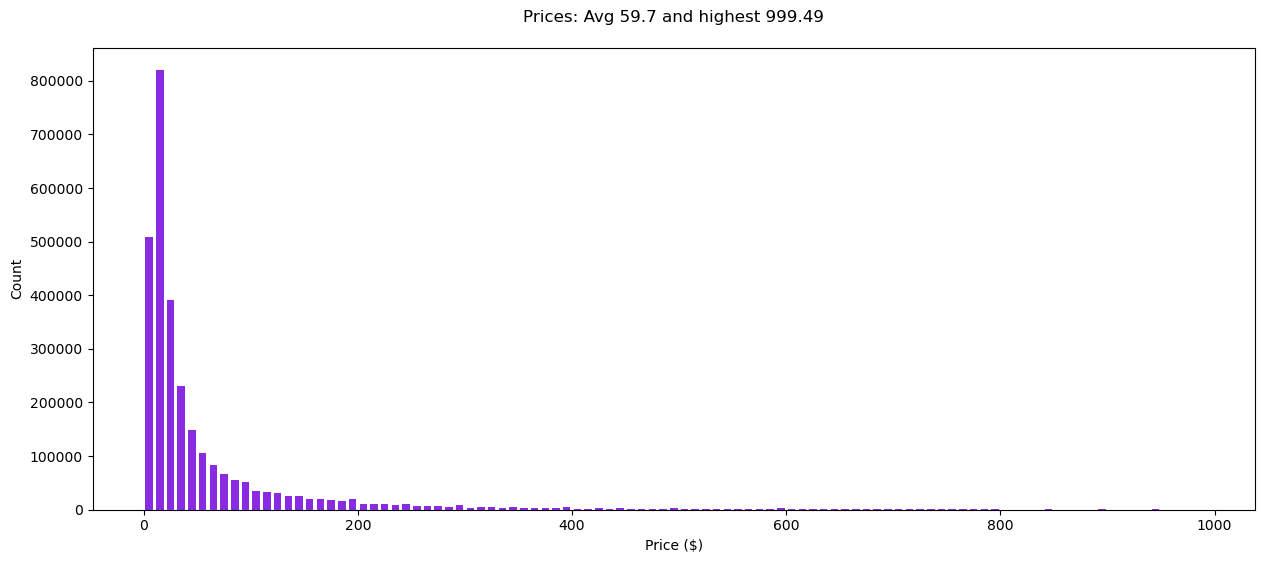

In [23]:
# Plot the distribution of prices

prices = [item.price for item in items]
plt.figure(figsize=(15, 6))
plt.title(f"Prices: Avg {sum(prices)/len(prices):,.1f} and highest {max(prices):,}\n")
plt.xlabel('Price ($)')
plt.ylabel('Count')
plt.hist(prices, rwidth=0.7, color="blueviolet", bins=range(0, 1000, 10))
plt.show()

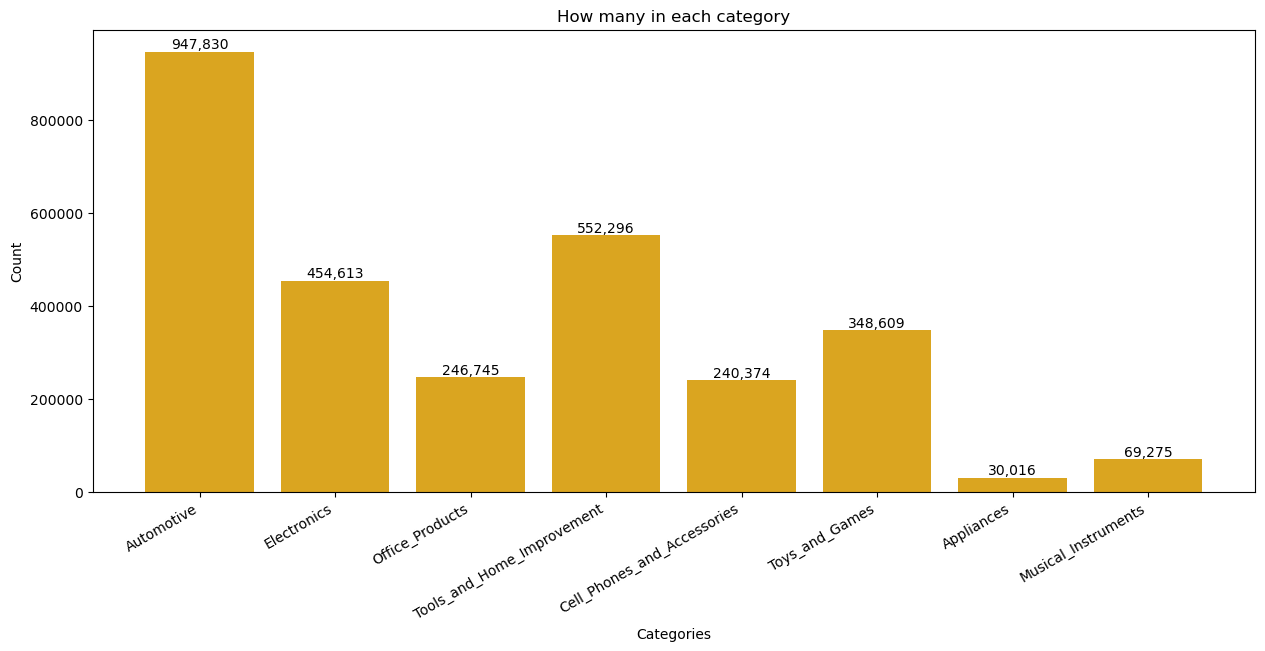

In [24]:
category_counts = Counter()
for item in items:
    category_counts[item.category]+=1

categories = category_counts.keys()
counts = [category_counts[category] for category in categories]

# Bar chart by category
plt.figure(figsize=(15, 6))
plt.bar(categories, counts, color="goldenrod")
plt.title('How many in each category')
plt.xlabel('Categories')
plt.ylabel('Count')

plt.xticks(rotation=30, ha='right')

# Add value labels on top of each bar
for i, v in enumerate(counts):
    plt.text(i, v, f"{v:,}", ha='center', va='bottom')

# Display the chart
plt.show()

# Objective

Craft a dataset which is more balanced in terms of prices. Less heavily scewed to cheap items, with an average that's higher than $60. Try to balance out the categories - fewer Automotive items.

In [25]:
# Create a dict with a key of each price from $1 to $999
# And in the value, put a list of items with that price (to nearest round number)

slots = defaultdict(list)
for item in items:
    slots[round(item.price)].append(item)

In [26]:
# Create a dataset called "sample" which tries to more evenly take from the range of prices
# And gives more weight to items from categories other than Automotive
# Set random seed for reproducibility

np.random.seed(42)
random.seed(42)
sample = []
for i in range(1, 1000):
    slot = slots[i]
    if i>=240:
        sample.extend(slot)
    elif len(slot) <= 1200:
        sample.extend(slot)
    else:
        weights = np.array([1 if item.category=='Automotive' else 5 for item in slot])
        weights = weights / np.sum(weights)
        selected_indices = np.random.choice(len(slot), size=1200, replace=False, p=weights)
        selected = [slot[i] for i in selected_indices]
        sample.extend(selected)

print(f"There are {len(sample):,} items in the sample")

There are 413,726 items in the sample


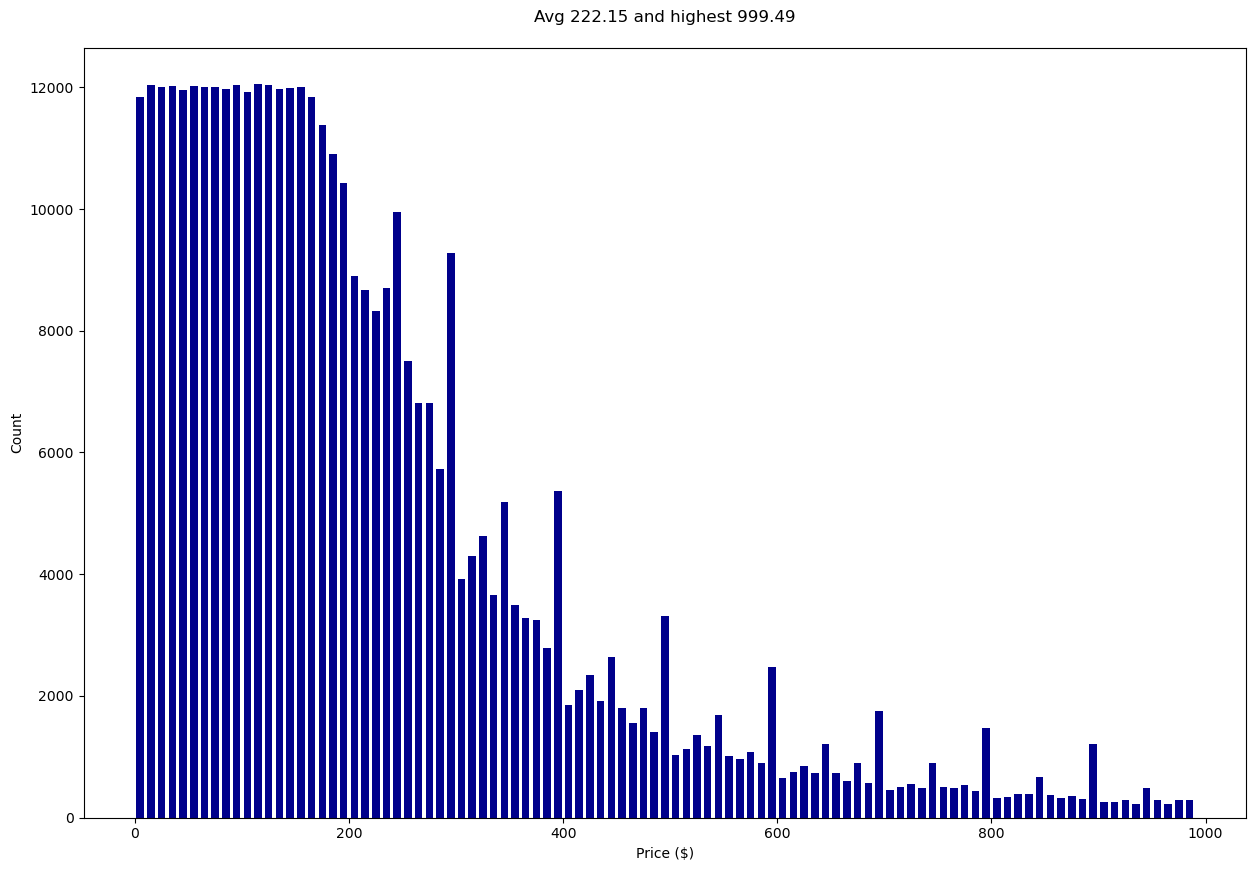

In [27]:
# Plot the distribution of prices in sample

prices = [float(item.price) for item in sample]
plt.figure(figsize=(15, 10))
plt.title(f"Avg {sum(prices)/len(prices):.2f} and highest {max(prices):,.2f}\n")
plt.xlabel('Price ($)')
plt.ylabel('Count')
plt.hist(prices, rwidth=0.7, color="darkblue", bins=range(0, 1000, 10))
plt.show()

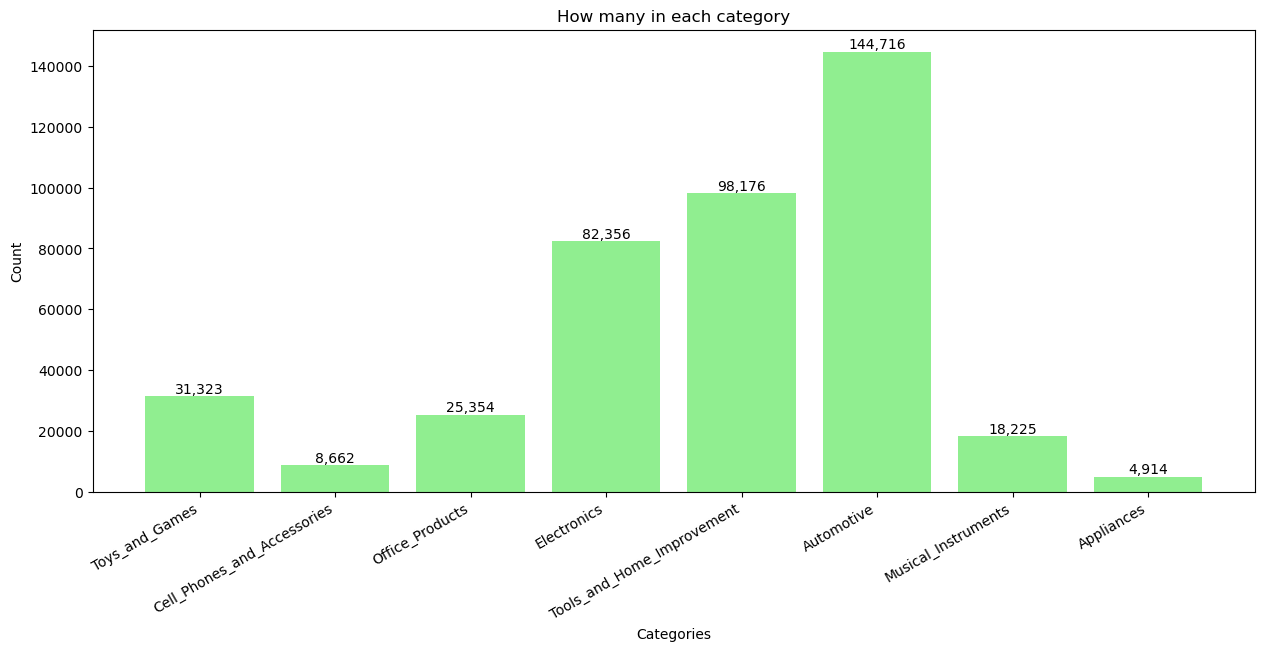

In [28]:
# OK, we did well in terms of raising the average price and having a smooth-ish population of prices
# Let's see the categories

category_counts = Counter()
for item in sample:
    category_counts[item.category]+=1

categories = category_counts.keys()
counts = [category_counts[category] for category in categories]

# Create bar chart
plt.figure(figsize=(15, 6))
plt.bar(categories, counts, color="lightgreen")

# Customize the chart
plt.title('How many in each category')
plt.xlabel('Categories')
plt.ylabel('Count')

plt.xticks(rotation=30, ha='right')

# Add value labels on top of each bar
for i, v in enumerate(counts):
    plt.text(i, v, f"{v:,}", ha='center', va='bottom')

# Display the chart
plt.show()

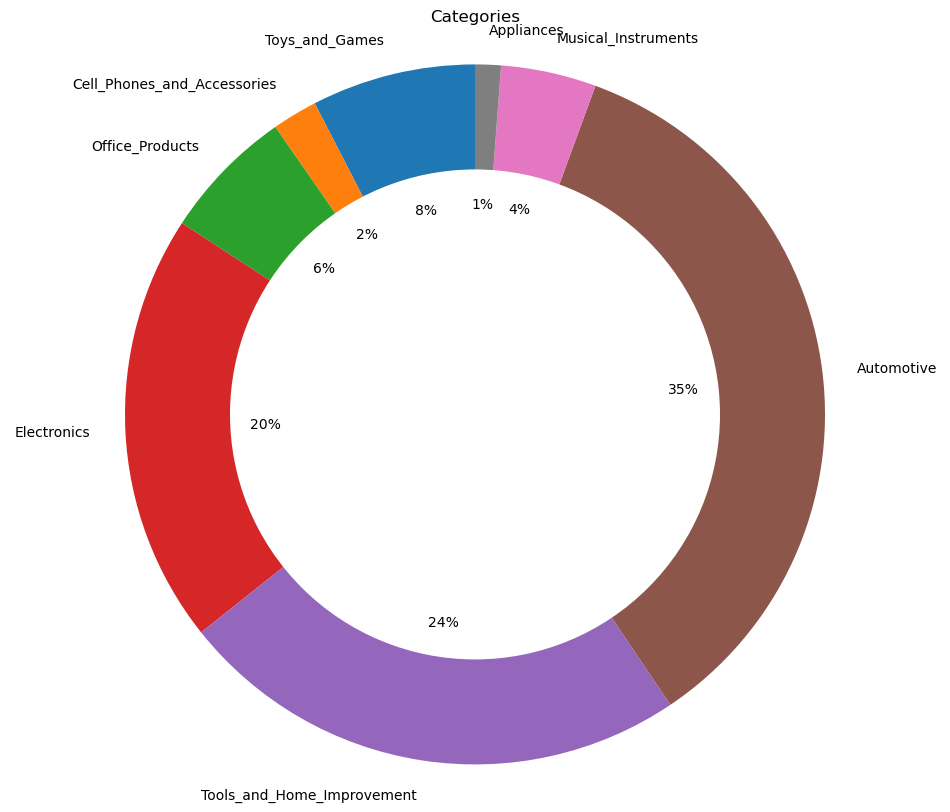

In [29]:
# Automotive still in the lead, but improved somewhat
# For another perspective, let's look at a pie

plt.figure(figsize=(12, 10))
plt.pie(counts, labels=categories, autopct='%1.0f%%', startangle=90)

# Add a circle at the center to create a donut chart (optional)
centre_circle = plt.Circle((0,0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.title('Categories')

# Equal aspect ratio ensures that pie is drawn as a circle
plt.axis('equal')  

plt.show()

# Dataset Curated!

We've crafted an excellent dataset.

Let's do some final checks

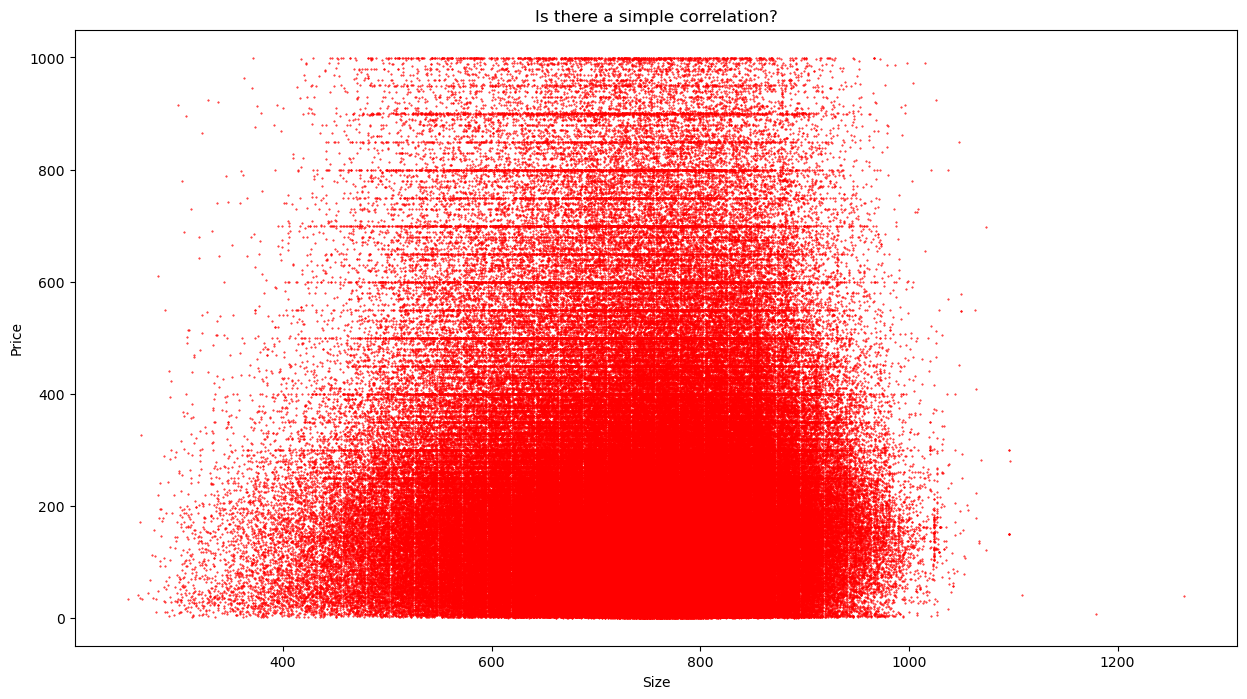

In [30]:
# How does the price vary with the character count of the prompt?

sizes = [len(item.prompt) for item in sample]
prices = [item.price for item in sample]

# Create the scatter plot
plt.figure(figsize=(15, 8))
plt.scatter(sizes, prices, s=0.2, color="red")

# Add labels and title
plt.xlabel('Size')
plt.ylabel('Price')
plt.title('Is there a simple correlation?')

# Display the plot
plt.show()

In [31]:
def report(item):
    prompt = item.prompt
    tokens = Item.tokenizer.encode(item.prompt)
    print(prompt)
    print(tokens[-10:])
    print(Item.tokenizer.batch_decode(tokens[-10:]))

In [32]:
report(sample[398000])

How much does this cost to the nearest dollar?

XTOOL D8 Car Diagnostic Scanner 2023 Newest with 3 Years Updates, Bidirectional Scan Tool with CAN FD, ECU Coding, 38+ Resets, Key Programming, Crankshaft Sensors Relearn, Full System Diagnostics
A Reliable & Affordable ALL-IN-ONE Car Diagnostic Scanner 2023 Newest Version XTOOL D8 scanner features Advance ECU Coding & Online Coding, Full Bi-Directional Controls, OE-Level All Systems Diagnose, 38+ Resets, Key Programming, supports CAN FD protocol for GM 2020MY and forward cars, it equipped with premium hardware for fast multitasking. XTOOL D8 would really come in handy if you have your own auto repair shop, it is also perfect for

Price is $699.00
[271, 6972, 374, 400, 21, 24, 24, 13, 15, 15]
['\n\n', 'Price', ' is', ' $', '6', '9', '9', '.', '0', '0']


## Observation

An interesting thing about the Llama tokenizer is that every number from 1 to 999 gets mapped to 1 token, much as we saw with gpt-4o. The same is not true of qwen2, gemma and phi3, which all map individual digits to tokens. This does turn out to be a bit useful for our project, although it's not an essential requirement.

# Finally

It's time to break down our data into a training, test and validation dataset.

It's typical to use 5%-10% of your data for testing purposes, but actually we have far more than we need at this point. We'll take 400,000 points for training, and we'll reserve 2,000 for testing, although we won't use all of them.


In [33]:
random.seed(42)
random.shuffle(sample)
train = sample[:400_000]
test = sample[400_000:402_000]
print(f"Divided into a training set of {len(train):,} items and test set of {len(test):,} items")

Divided into a training set of 400,000 items and test set of 2,000 items


In [34]:
print(train[0].prompt)

How much does this cost to the nearest dollar?

2 Pack JBL Clip 4 Waterproof Wireless Audio Bluetooth Speaker Bundle (Black)
IT'S ALL ABOUT THE SOUND! Music here, there, everywhere. Clip and play, cool, portable, and waterproof! The vibrant fresh looking JBL Clip 4 delivers surprisingly rich JBL Original Pro Sound in a compact package. The unique oval shape fits easy in your hand. Fully wrapped in colorful fabrics with expressive details inspired by current street fashion, it’s easy to match your style. The fully integrated carabiner hooks instantly to bags, belts, or buckles, to bring your favorite tunes anywhere. Waterproof, dustproof, and up to 10 hours of playtime, it’s rugged enough to tag along wherever you explore. This Exclusive Bundle includes two JBL Clip 4 speakers .Cool,

Price is $98.00


In [35]:
print(test[0].test_prompt())

How much does this cost to the nearest dollar?

USB 3.0 Hub ORICO Powered 13 Ports USB Data Hub with Individual Switches and Indicator, 12V Power Adapter Support BC1.2 Charging, USB Extension for iMac Pro, MacBook Air/Mini, PS4, Surface Pro, PC
Super Speed Data Transfer and High Stable Connection USB 3.0 splitter hub supports transfer rate of up to 5 Gbps data to achieve fast transfer between devices so that you can now transfer HD Movies in no time. Each USB fast charging ports can deliver up to 2.4A Max of current, ideal for your iPad/tablet, and other USB devices. Individual Switches and Light ORICO usb switch hub equipped with convenient swith and LED indicator for each USB port to know the status easily and which is

Price is $


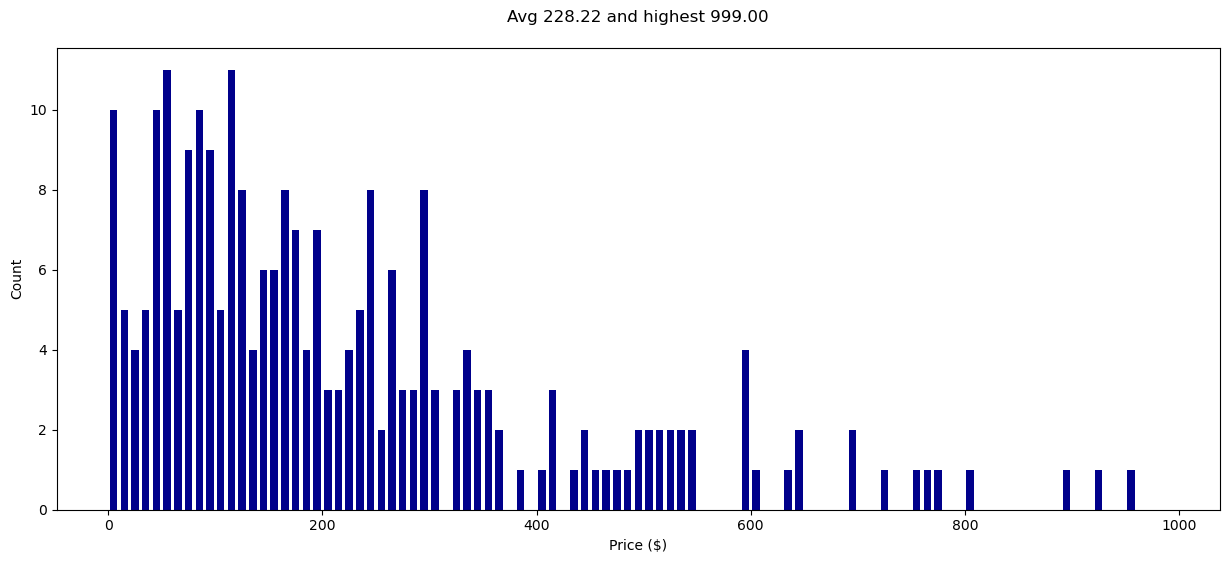

In [36]:
# Plot the distribution of prices in the first 250 test points

prices = [float(item.price) for item in test[:250]]
plt.figure(figsize=(15, 6))
plt.title(f"Avg {sum(prices)/len(prices):.2f} and highest {max(prices):,.2f}\n")
plt.xlabel('Price ($)')
plt.ylabel('Count')
plt.hist(prices, rwidth=0.7, color="darkblue", bins=range(0, 1000, 10))
plt.show()

# Finally - upload your brand new dataset

Convert to prompts and upload to HuggingFace hub

In [37]:
train_prompts = [item.prompt for item in train]
train_prices = [item.price for item in train]
test_prompts = [item.test_prompt() for item in test]
test_prices = [item.price for item in test]

In [38]:
# Create a Dataset from the lists

train_dataset = Dataset.from_dict({"text": train_prompts, "price": train_prices})
test_dataset = Dataset.from_dict({"text": test_prompts, "price": test_prices})
dataset = DatasetDict({
    "train": train_dataset,
    "test": test_dataset
})

In [40]:
# Uncomment these lines if you're ready to push to the hub, and replace my name with your HF username

HF_USER = "jaguuai"
DATASET_NAME = f"{HF_USER}/pricer-data"
dataset.push_to_hub(DATASET_NAME, private=True)

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/400 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

README.md:   0%|          | 0.00/416 [00:00<?, ?B/s]

No files have been modified since last commit. Skipping to prevent empty commit.


CommitInfo(commit_url='https://huggingface.co/datasets/jaguuai/pricer-data/commit/bb4165327783505b28a07b565715bb66b0ca46d8', commit_message='Upload dataset', commit_description='', oid='bb4165327783505b28a07b565715bb66b0ca46d8', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/jaguuai/pricer-data', endpoint='https://huggingface.co', repo_type='dataset', repo_id='jaguuai/pricer-data'), pr_revision=None, pr_num=None)

In [41]:
# One more thing!
# Let's pickle the training and test dataset so we don't have to execute all this code next time!

with open('train.pkl', 'wb') as file:
    pickle.dump(train, file)

with open('test.pkl', 'wb') as file:
    pickle.dump(test, file)